# Evaluation Metrics for KD Models
## 1. Perturbation Sensitivity (FashionMNIST)

Utilizing Fourier Spectrum Analysis


In [ ]:
import torch
import gc


# Clear GPU cache

# Run garbage collection

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()


# Optionally, synchronize to avoid lingering GPU operations


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import fft2, fftshift, ifft2
from torchvision.transforms import ToPILImage
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import random
import torchvision.transforms.functional as TF
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision import datasets

class ModifiedResNet50(nn.Module):
    def _init_(self):
        super(ModifiedResNet50, self)._init_()
        self.base_model = models.resnet50(pretrained=False)
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])
        self.pool = self.base_model.avgpool
        self.fc = self.base_model.fc

    def forward(self, x):
        feature_maps = self.features(x)
        pooled_features = self.pool(feature_maps)
        flattened_features = pooled_features.view(pooled_features.size(0), -1)
        logits = self.fc(flattened_features)
        return feature_maps, logits

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
loader_occluded_val = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

class FeatureExtractor:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.features = None
        self.hook = None
        self.register_hook()

    def hook_fn(self, module, input, output):
        self.features = output

    def register_hook(self):
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hook = module.register_forward_hook(self.hook_fn)

    def remove_hook(self):
        if self.hook:
            self.hook.remove()

# control_model = torch.load("/content/drive/MyDrive/Tahir/cifar/control_cifar_student_model_epoch_5.pth")
# student_model = torch.load("/content/drive/MyDrive/Tahir/cifar/cifar_student_model_epoch_6.pth")
# teacher_model = torch.load("/content/drive/MyDrive/Tahir/cifar/cifar_teacher_model_9.pth")


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Fourier

Files already downloaded and verified


<ipython-input-21-fe440df79472>:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  control_model = torch.load("/content/drive/MyDrive/Tahir/resnet_student_cifar")
<ipython-i

control_student Model Low-Pass Accuracy: 16.38%
control_student Model High-Pass Accuracy: 34.58%
Student Model Low-Pass Accuracy: 27.39%
Student Model High-Pass Accuracy: 43.47%


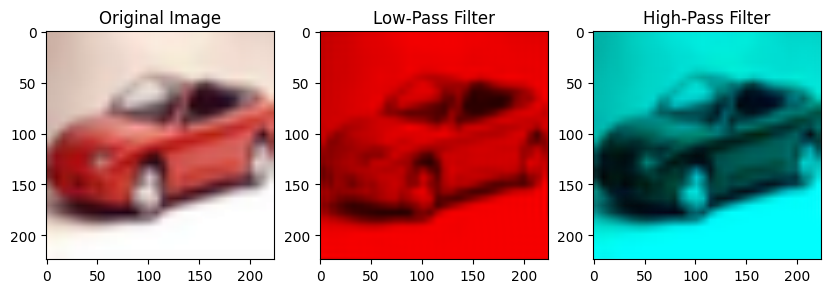

In [ ]:


def apply_fourier_transform(image):
    """Apply Fourier Transform to an image and return magnitude and phase."""
    if image.ndim == 3:
        image = image.unsqueeze(0)

    batch_size, channels, height, width = image.size()
    f_transform = fft2(image)
    f_shift = fftshift(f_transform, dim=(-2, -1))
    magnitude = torch.abs(f_shift)
    phase = torch.angle(f_shift)
    return magnitude, phase


def apply_low_pass_filter(magnitude, radius):
    """Apply a low-pass filter to the magnitude."""
    if magnitude.ndim == 3:
        magnitude = magnitude.unsqueeze(0)

    batch_size, _, height, width = magnitude.shape
    center_x, center_y = height // 2, width // 2
    y, x = torch.meshgrid(
        torch.arange(height, device=magnitude.device),
        torch.arange(width, device=magnitude.device),
        indexing="ij",
    )
    distance = ((x - center_x) ** 2 + (y - center_y) ** 2).sqrt()
    mask = torch.zeros_like(magnitude)
    mask[:, 0, distance <= radius] = 1
    return magnitude * mask

def apply_high_pass_filter(magnitude, radius):
    """Apply a high-pass filter to the magnitude."""
    if magnitude.ndim == 3:
        magnitude = magnitude.unsqueeze(0)

    batch_size, _, height, width = magnitude.shape
    center_x, center_y = height // 2, width // 2
    y, x = torch.meshgrid(
        torch.arange(height, device=magnitude.device),
        torch.arange(width, device=magnitude.device),
        indexing="ij",
    )
    distance = ((x - center_x) ** 2 + (y - center_y) ** 2).sqrt()
    mask = torch.ones_like(magnitude)
    mask[:, 0, distance <= radius] = 0
    return magnitude * mask


def reconstruct_image(magnitude, phase):
    """Reconstruct an image from its magnitude and phase."""
    f_shift = magnitude * torch.exp(1j * phase)
    f_transform = ifft2(f_shift)
    f_image = torch.abs(f_transform)
    return f_image


# Step 2: Load Texturized FashionMNIST


# transform = Compose([ToTensor(),])
# dataset = FashionMNIST(root="./data", train=False, transform=transform, download=True)
# data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# class AddOcclusion:
#     def __init__(self, occlusion_size=16):
#         self.occlusion_size = occlusion_size  # Size of the blacked-out region

#     def __call__(self, img):
#         # Ensure the input is a tensor
#         if isinstance(img, Image.Image):
#             img = F.to_tensor(img)

#         # Ensure the tensor has 3 dimensions (C, H, W)
#         if len(img.shape) != 3:
#             raise TypeError(f"Expected tensor with 3 dimensions (C, H, W). Got {img.shape}")

#         _, h, w = img.shape
#         x_start = random.randint(0, w - self.occlusion_size)
#         y_start = random.randint(0, h - self.occlusion_size)

#         # Black out the region
#         img[:, y_start:y_start + self.occlusion_size, x_start:x_start + self.occlusion_size] = 0
#         return img

# transform_occluded = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     AddOcclusion(occlusion_size=96),
# ])


# dataset_occluded_val = datasets.STL10(root='./data', split='test', download=True, transform=transform_occluded)
# loader_occluded_val = DataLoader(dataset_occluded_val, batch_size=64, shuffle=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
loader_occluded_val = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

control_model = torch.load("/content/drive/MyDrive/Tahir/resnet_student_cifar")
student_model = torch.load("/content/drive/MyDrive/Tahir/cifar/cifar_student_model_epoch_6.pth")

def evaluate_on_filtered_images(model, data_loader, filter_type, radius):
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        magnitude, phase = apply_fourier_transform(inputs)

        if filter_type == "low_pass":
            filtered_magnitude = apply_low_pass_filter(magnitude, radius)
        elif filter_type == "high_pass":
            filtered_magnitude = apply_high_pass_filter(magnitude, radius)

        filtered_image = reconstruct_image(filtered_magnitude, phase)

        if len(filtered_image.shape) == 3:
            filtered_image = filtered_image.unsqueeze(1)

        filtered_image = filtered_image.expand(-1, 3, -1, -1)
        outputs = model(filtered_image)

        if isinstance(outputs, tuple):
            logits = outputs[1]
        else:
            logits = outputs

        _, predicted = torch.max(logits, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy




low_pass_radius = 30
high_pass_radius = 10

control_student_low_pass_acc = evaluate_on_filtered_images(control_model, loader_occluded_val, "low_pass", low_pass_radius)
control_student_high_pass_acc = evaluate_on_filtered_images(control_model, loader_occluded_val, "high_pass", high_pass_radius)

student_low_pass_acc = evaluate_on_filtered_images(student_model, loader_occluded_val, "low_pass", low_pass_radius)
student_high_pass_acc = evaluate_on_filtered_images(student_model, loader_occluded_val, "high_pass", high_pass_radius)

print(f"control_student Model Low-Pass Accuracy: {control_student_low_pass_acc:.2f}%")
print(f"control_student Model High-Pass Accuracy: {control_student_high_pass_acc:.2f}%")
print(f"Student Model Low-Pass Accuracy: {student_low_pass_acc:.2f}%")
print(f"Student Model High-Pass Accuracy: {student_high_pass_acc:.2f}%")

def visualize_filtered_images(inputs, radius):
    magnitude, phase = apply_fourier_transform(inputs)
    low_pass = apply_low_pass_filter(magnitude, radius)
    high_pass = apply_high_pass_filter(magnitude, radius)
    low_pass_image = reconstruct_image(low_pass, phase)
    high_pass_image = reconstruct_image(high_pass, phase)

    original_image = inputs.permute(1, 2, 0).cpu().numpy()
    low_pass_image = low_pass_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    high_pass_image = high_pass_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
    low_pass_image = (low_pass_image - low_pass_image.min()) / (low_pass_image.max() - low_pass_image.min())
    high_pass_image = (high_pass_image - high_pass_image.min()) / (high_pass_image.max() - high_pass_image.min())

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 3, 2)
    plt.title("Low-Pass Filter")
    plt.imshow(low_pass_image)

    plt.subplot(1, 3, 3)
    plt.title("High-Pass Filter")
    plt.imshow(high_pass_image)
    plt.show()



for inputs, _ in loader_occluded_val:
    visualize_filtered_images(inputs[0], low_pass_radius)
    break


In [ ]:
# import random
# from PIL import Image  # Import PIL.Image to handle image processing
# import torchvision.transforms.functional as F
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# # Custom transform to add localized occlusions
# class AddOcclusion:
#     def __init__(self, occlusion_size=16):
#         self.occlusion_size = occlusion_size  # Size of the blacked-out region

#     def __call__(self, img):
#         # Ensure the input is a tensor
#         if isinstance(img, Image.Image):
#             img = F.to_tensor(img)

#         # Ensure the tensor has 3 dimensions (C, H, W)
#         if len(img.shape) != 3:
#             raise TypeError(f"Expected tensor with 3 dimensions (C, H, W). Got {img.shape}")

#         _, h, w = img.shape
#         x_start = random.randint(0, w - self.occlusion_size)
#         y_start = random.randint(0, h - self.occlusion_size)

#         # Black out the region
#         img[:, y_start:y_start + self.occlusion_size, x_start:x_start + self.occlusion_size] = 0
#         return img


# transform_occluded = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),        # Convert to tensor for PyTorch
#     AddOcclusion(occlusion_size=96),  # Add 32x32 occlusion
# ])

# transform_default = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),        # Convert to tensor for PyTorch
# ])

# # Create occluded dataset
# dataset_occluded_train = datasets.STL10(root='./data', split='train', download=True, transform=transform_default)
# dataset_occluded_val = datasets.STL10(root='./data', split='test', download=True, transform=transform_occluded)
# # DataLoader for occluded dataset
# loader_occluded_val = DataLoader(dataset_occluded_train, batch_size=64, shuffle=True)
# loader_occluded_train = DataLoader(dataset_occluded_val, batch_size=64, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


#CKA

In [ ]:
!pip install torch-cka

In [ ]:
import torch
from collections import defaultdict
import torchvision.transforms as T
from torchvision.transforms.functional import normalize


class FeatureExtractor:
    def __init__(self, model, layer_names):
        self.model = model
        self.layer_names = layer_names
        self.features = defaultdict(list)
        self.hooks = []

        for name, module in model.named_modules():
            if name in layer_names:
                hook = module.register_forward_hook(self.save_features(name))
                self.hooks.append(hook)

    def save_features(self, layer_name):
        def hook(module, input, output):
            self.features[layer_name].append(output)
        return hook

    def clear(self):
        self.features.clear()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()


def centering(matrix):
    """Center the matrix for HSIC computation."""
    return matrix - matrix.mean(dim=0, keepdim=True) - matrix.mean(dim=1, keepdim=True) + matrix.mean()


def hsic(X, Y):
    """
    Compute the HSIC value between two feature maps X and Y.
    X, Y: [n_samples, n_features]
    """
    n = X.size(0)
    K = X @ X.T
    L = Y @ Y.T
    H = centering(torch.eye(n, device=X.device))
    return torch.trace(K @ H @ L @ H) / (n - 1) ** 2


def cka_similarity(X, Y):
    """
    Compute CKA similarity between two feature maps X and Y.
    """
    hsic_xy = hsic(X, Y)
    hsic_xx = hsic(X, X)
    hsic_yy = hsic(Y, Y)
    return hsic_xy / (hsic_xx.sqrt() * hsic_yy.sqrt())


control_model.eval()
student_model.eval()
teacher_model.eval()

teacher_layers = [
    "encoder.layers.encoder_layer_0.mlp.3",
    "encoder.layers.encoder_layer_1.self_attention.out_proj"
]
control_layers = ["layer1.0.conv1", "layer2.0.conv1"]
student_layers = ["base_model.layer1.0.conv1", "base_model.layer2.0.conv1"]

teacher_extractor = FeatureExtractor(teacher_model, teacher_layers)
control_extractor = FeatureExtractor(control_model, control_layers)
student_extractor = FeatureExtractor(student_model, student_layers)

resize_transform = T.Resize((224, 224))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
control_model = control_model.to(device)
student_model = student_model.to(device)

with torch.no_grad():
    for batch_idx, (images, _) in enumerate(loader_occluded_val):
        if batch_idx >= 3:
            break
        resized_images = resize_transform(images)

        if resized_images.size(1) == 1:
            resized_images = resized_images.repeat(1, 3, 1, 1)

        resized_images = normalize(resized_images, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)
        images = normalize(images, mean=[0.5], std=[0.5]).to(device)

        resized_images = resized_images.to(device)
        images = images.to(device)

        _ = teacher_model(resized_images)
        _ = control_model(resized_images)
        _ = student_model(images)

def extract_features(extractor, layers):
    features = []
    for layer in layers:
        if layer in extractor.features and len(extractor.features[layer]) > 0:
            concatenated_features = torch.cat(extractor.features[layer], dim=0)
            features.append(concatenated_features)
        else:
            print(f"Warning: No features captured for layer {layer}.")
    return features


teacher_features = extract_features(teacher_extractor, teacher_layers)
control_features = extract_features(control_extractor, control_layers)
student_features = extract_features(student_extractor, student_layers)

if len(teacher_features) == 0 or len(control_features) == 0 or len(student_features) == 0:
    raise ValueError("No valid features captured for CKA computation. Please check your feature extraction setup.")

def compute_cka(features_a, features_b, name_a, name_b):
    similarities = {}
    for feat_a, feat_b, layer_a, layer_b in zip(features_a, features_b, teacher_layers, control_layers + student_layers):
        feat_a_flat = feat_a.view(feat_a.size(0), -1)
        feat_b_flat = feat_b.view(feat_b.size(0), -1)
        similarity = cka_similarity(feat_a_flat, feat_b_flat).item()
        similarities[f"{name_a} Layer {layer_a} ↔ {name_b} Layer {layer_b}"] = similarity
    return similarities


teacher_control_similarity = compute_cka(teacher_features, control_features, "Teacher", "Control")

teacher_student_similarity = compute_cka(teacher_features, student_features, "Teacher", "Student")

print("CKA Similarity Results:")
for name, similarity in {"Teacher ↔ Control": teacher_control_similarity, "Teacher ↔ Student": teacher_student_similarity}.items():
    print(f"\n{name} Results:")
    for layer_pair, score in similarity.items():
        print(f"{layer_pair}: {score:.4f}")


TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [ ]:
import torch
from collections import defaultdict
import torchvision.transforms as T
from torchvision.transforms.functional import normalize


class FeatureExtractor:
    def __init__(self, model, layer_names):
        self.model = model
        self.layer_names = layer_names
        self.features = defaultdict(list)
        self.hooks = []

        for name, module in model.named_modules():
            if name in layer_names:
                hook = module.register_forward_hook(self.save_features(name))
                self.hooks.append(hook)

    def save_features(self, layer_name):
        def hook(module, input, output):
            if isinstance(output, tuple):
                self.features[layer_name].append(output[0])
            else:
                self.features[layer_name].append(output)
        return hook

    def clear(self):
        self.features.clear()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()



def centering(matrix):
    """Center the matrix for HSIC computation."""
    return matrix - matrix.mean(dim=0, keepdim=True) - matrix.mean(dim=1, keepdim=True) + matrix.mean()


def hsic(X, Y):
    """
    Compute the HSIC value between two feature maps X and Y.
    X, Y: [n_samples, n_features]
    """
    n = X.size(0)
    K = X @ X.T
    L = Y @ Y.T
    H = centering(torch.eye(n, device=X.device))
    return torch.trace(K @ H @ L @ H) / (n - 1) ** 2


def cka_similarity(X, Y):
    """
    Compute CKA similarity between two feature maps X and Y.
    """
    hsic_xy = hsic(X, Y)
    hsic_xx = hsic(X, X)
    hsic_yy = hsic(Y, Y)
    return hsic_xy / (hsic_xx.sqrt() * hsic_yy.sqrt())


control_model.eval()
student_model.eval()
teacher_model.eval()

teacher_layers = [
    "encoder.layers.encoder_layer_1.self_attention",
    "encoder.layers.encoder_layer_1.mlp.0"
]
control_layers = [
    "layer1.0.conv1",
    "layer2.0.conv3"
]
student_layers = [
    "base_model.layer1.0.conv1",
    "base_model.layer2.0.conv3"
]
teacher_extractor = FeatureExtractor(teacher_model, teacher_layers)
control_extractor = FeatureExtractor(control_model, control_layers)
student_extractor = FeatureExtractor(student_model, student_layers)

resize_transform = T.Resize((224, 224))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
control_model = control_model.to(device)
student_model = student_model.to(device)

with torch.no_grad():
    for batch_idx, (images, _) in enumerate(loader_occluded_val):
        if batch_idx >= 3:
            break
        resized_images = resize_transform(images)

        if resized_images.size(1) == 1:
            resized_images = resized_images.repeat(1, 3, 1, 1)

        resized_images = normalize(resized_images, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)
        images = normalize(images, mean=[0.5], std=[0.5]).to(device)

        resized_images = resized_images.to(device)
        images = images.to(device)

        _ = teacher_model(resized_images)
        _ = control_model(resized_images)
        _ = student_model(images)

def extract_features(extractor, layers):
    features = []
    for layer in layers:
        if layer in extractor.features and len(extractor.features[layer]) > 0:
            concatenated_features = torch.cat(extractor.features[layer], dim=0)
            features.append(concatenated_features)
        else:
            print(f"Warning: No features captured for layer {layer}.")
    return features


teacher_features = extract_features(teacher_extractor, teacher_layers)
control_features = extract_features(control_extractor, control_layers)
student_features = extract_features(student_extractor, student_layers)

if len(teacher_features) == 0 or len(control_features) == 0 or len(student_features) == 0:
    raise ValueError("No valid features captured for CKA computation. Please check your feature extraction setup.")

def compute_cka(features_a, features_b, name_a, name_b):
    similarities = {}
    for feat_a, feat_b, layer_a, layer_b in zip(features_a, features_b, teacher_layers, control_layers + student_layers):
        feat_a_flat = feat_a.view(feat_a.size(0), -1)
        feat_b_flat = feat_b.view(feat_b.size(0), -1)
        similarity = cka_similarity(feat_a_flat, feat_b_flat).item()
        similarities[f"{name_a} Layer {layer_a} ↔ {name_b} Layer {layer_b}"] = similarity
    return similarities


teacher_control_similarity = compute_cka(teacher_features, control_features, "Teacher", "Control")

teacher_student_similarity = compute_cka(teacher_features, student_features, "Teacher", "Student")

print("CKA Similarity Results:")
for name, similarity in {"Teacher ↔ Control": teacher_control_similarity, "Teacher ↔ Student": teacher_student_similarity}.items():
    print(f"\n{name} Results:")
    for layer_pair, score in similarity.items():
        print(f"{layer_pair}: {score:.4f}")


CKA Similarity Results:

Teacher ↔ Control Results:
Teacher Layer encoder.layers.encoder_layer_1.self_attention ↔ Control Layer layer1.0.conv1: 0.4551
Teacher Layer encoder.layers.encoder_layer_1.mlp.0 ↔ Control Layer layer2.0.conv3: 0.3471

Teacher ↔ Student Results:
Teacher Layer encoder.layers.encoder_layer_1.self_attention ↔ Student Layer layer1.0.conv1: 0.4549
Teacher Layer encoder.layers.encoder_layer_1.mlp.0 ↔ Student Layer layer2.0.conv3: 0.3420
